In [41]:
# =========================================================
# 1. Imports
# =========================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

In [42]:
# =========================================================
# 2. Load dataset
# =========================================================
df = pd.read_csv("data/online_shoppers_intention.csv")
print("Dataset loaded:", df.shape)

Dataset loaded: (12330, 18)


In [ ]:
# =========================================================
# 3. Convert boolean variables to numeric
# =========================================================
df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)


# =========================================================
# 4. Group rare categories in numeric-categorical features
# =========================================================
numeric_categorical = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

def group_rare(series, threshold=50):
    freq = series.value_counts()
    return series.apply(lambda x: x if freq[x] > threshold else "Other")

for col in numeric_categorical:
    df[col] = df[col].astype(str)
    df[col] = group_rare(df[col])


# =========================================================
# 5. Define categorical & numerical sets
# =========================================================
categorical_nominal = ['Month', 'VisitorType'] + numeric_categorical
numerical_features_original = [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues',
    'SpecialDay'
]


# =========================================================
# 6. Train-test split (BEFORE encoding!)
# =========================================================
X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("After split:", len(X_train), len(y_train))


# =========================================================
# 7. Log-transform duration columns
# =========================================================
for col in ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])


# =========================================================
# 8. Fit OneHotEncoder on TRAIN split
# =========================================================
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_nominal])

# Transform
X_train_cat = encoder.transform(X_train[categorical_nominal])
X_test_cat  = encoder.transform(X_test[categorical_nominal])

print("After encoding, before dropping:", len(X_train))

X_train = X_train.drop(columns=categorical_nominal)
X_test = X_test.drop(columns=categorical_nominal)

print("After dropping categoricals:", len(X_train))

# Get feature names (optional)
encoded_cols = encoder.get_feature_names_out(categorical_nominal)


# =========================================================
# Define numerical columns AUTOMATICALLY
# =========================================================
numerical_features = X_train.select_dtypes(include=[np.number]).columns

X_train_num = X_train[numerical_features].reset_index(drop=True)
X_test_num  = X_test[numerical_features].reset_index(drop=True)


X_train_full = np.hstack([X_train_num.values, X_train_cat])
X_test_full  = np.hstack([X_test_num.values,  X_test_cat])


print("After building X_train_full:", X_train_full.shape[0])

# =========================================================
# 10. Scale numerical + encoded features
# =========================================================
scaler = StandardScaler()

print("Before scaling:", len(X_train_full))


X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled  = scaler.transform(X_test_full)

print("After scaling:", len(X_train_scaled))



# # =========================================================
# # 11. PCA (for visualization only)
# # =========================================================
# pca = PCA(n_components=2)
# pca.fit(X_train_scaled)

# X_train_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# # =========================================================
# # 12. SMOTE (APPLY ONLY ON SCALED DATA, ONLY FOR TRAINING MODELS THAT NEED IT)
# # =========================================================
# # Example: only for tree models, not for LogisticRegression

# smote = SMOTE(random_state=0)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# print("After SMOTE:", X_train_smote.shape)


Train: (9864, 17)  Test: (2466, 17)
After split: 9864 9864
After encoding, before dropping: 9864
After dropping categoricals: 9864
After building X_train_full: 9864
Before scaling: 9864
After scaling: 9864
After SMOTE: (16676, 55)


/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encounter

# LOGISTIC REGRESSION

In [38]:
# =========================================================
# 2.1 Imports
# =========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [54]:
# =========================================================
# 2.2 Train Logistic Regression
# =========================================================
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ 

LogisticRegression(class_weight='balanced')

In [56]:
# =========================================================
# 2.3 Evaluate the model
# =========================================================

y_pred = model.predict(X_test_scaled)

# evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1781  303]
 [  98  284]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      2084
           1       0.48      0.74      0.59       382

    accuracy                           0.84      2466
   macro avg       0.72      0.80      0.74      2466
weighted avg       0.88      0.84      0.85      2466



/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


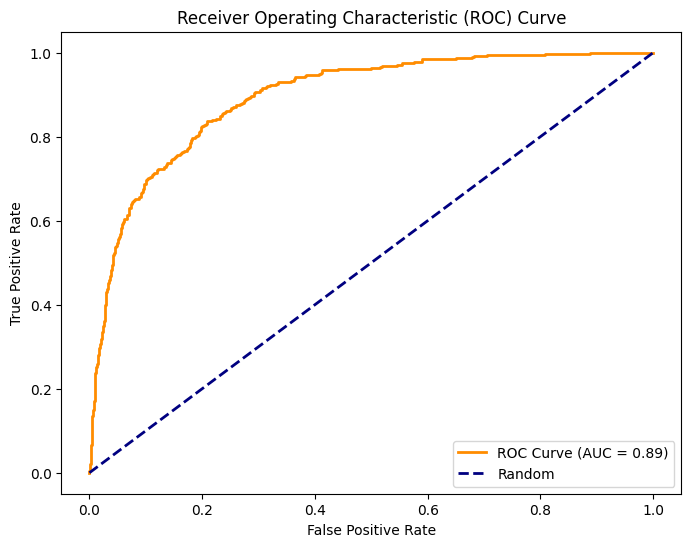

In [59]:
# =========================================================
# 2.4 ROC Curve
# =========================================================
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np

kf = KFold(n_splits=3, random_state=1, shuffle=True)

cvScores = []
i = 1

for train_index, test_index in kf.split(X_train_scaled):
    print(f"\nFold {i} =============================================================")
    
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train_cv, y_train_cv)
    
    y_pred = model.predict(X_val_cv)
    
    f1 = f1_score(y_val_cv, y_pred, pos_label=1)
    print(f"F1-score (class 1): {f1:.4f}")
    
    cvScores.append(f1)
    i += 1

print("\nMean F1:", np.mean(cvScores))
print("Std F1:", np.std(cvScores))



Fold 1 =============================================================
F1-score (class 1): 0.6034

Fold 2 =============================================================
F1-score (class 1): 0.5930

Fold 3 =============================================================
F1-score (class 1): 0.6316

Mean F1: 0.6093383427028463
Std F1: 0.016295985911049204


/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ 